In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
dataset = pd.read_csv("/content/sat and sun test2.csv")
dataset.head(2)

,Unnamed: 0,hours test,kwh test
0,1,0:00,80.24
1,2,0:01,7.50


In [ ]:
filtered_df = dataset.filter(items=['hours test', 'kwh test'], axis=1)

In [ ]:
filtered_df.head(2)

,hours test,kwh test
0,0:00,80.24
1,0:01,7.50


In [ ]:
filtered_df.isnull().sum()

hours test    0
kwh test      0
dtype: int64

In [ ]:
filtered_df.dtypes

hours test     object
kwh test      float64
dtype: object

In [ ]:
filtered_df.count()

hours test    1116
kwh test      1116
dtype: int64

In [ ]:
dataset['hours test'] = dataset['hours test'].apply(lambda x: pd.to_datetime(x).strftime('%H:%M'))
dataset.head(2)

,Unnamed: 0,hours test,kwh test
0,1,00:00,80.24
1,2,00:01,7.50


In [ ]:
sf_df = dataset[['hours test', 'kwh test']]

In [ ]:
sf_df.shape

(1116, 2)

In [ ]:
hours = dataset['hours test'].to_numpy()
kwh = dataset['kwh test'].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(Timesteps, Aqi, test_size = 0.08)

#split_size = int(0.8*len(Aqi))

#X_train,y_train = Timesteps[:split_size],Aqi[:split_size]
#X_test,y_test = Timesteps[split_size:],Aqi[split_size:]

split_size = int(0.8*len(kwh))

x_train,y_train = hours[:split_size],kwh[:split_size]
x_test,y_test = hours[split_size:],kwh[split_size:]

len(x_train), len(x_test), len(y_train), len(y_test)

(892, 224, 892, 224)

In [ ]:
viz_train = go.Scatter(
    x = x_train,
    y = y_train,
    mode = 'lines',
    name = 'Actual Train'
)

viz_test = go.Scatter(
    x = x_test,
    y = y_test,
    mode = 'lines',
    name = 'Actual Test'
)

layout = go.Layout(
    #title = 'Tuesdays (2018-2021)',
    xaxis = {'title' : "Time"},
    yaxis = {'title' : "kWh Delivered"}
)
fig = go.Figure(data=[viz_train, viz_test], layout=layout)

fig.update_layout(
    legend=dict(
        x=.8,
        y=.8,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=16,
            color="black"
        ),
    )
)

fig.show()

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
def make_windows(x, window_size=7, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]

  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(kwh, window_size=WINDOW_SIZE, horizon=HORIZON)

len(full_windows), len(full_labels)

(1086, 1086)

In [ ]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [ 80.24   7.5   59.48  46.85  83.28  40.75 121.35  25.25  66.5  106.23
  21.84  27.14  68.19  42.47  60.01  44.87  50.39 125.28  41.44  38.32
  89.71  18.23  37.01  54.23  39.6   89.85  67.71  92.24  86.38  24.14] -> Label: [100.16]
Window: [  7.5   59.48  46.85  83.28  40.75 121.35  25.25  66.5  106.23  21.84
  27.14  68.19  42.47  60.01  44.87  50.39 125.28  41.44  38.32  89.71
  18.23  37.01  54.23  39.6   89.85  67.71  92.24  86.38  24.14 100.16] -> Label: [6.44]
Window: [ 59.48  46.85  83.28  40.75 121.35  25.25  66.5  106.23  21.84  27.14
  68.19  42.47  60.01  44.87  50.39 125.28  41.44  38.32  89.71  18.23
  37.01  54.23  39.6   89.85  67.71  92.24  86.38  24.14 100.16   6.44] -> Label: [30.48]


In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(868, 218, 868, 218)

In [ ]:
train_windows[:5]

array([[ 80.24,   7.5 ,  59.48,  46.85,  83.28,  40.75, 121.35,  25.25,
         66.5 , 106.23,  21.84,  27.14,  68.19,  42.47,  60.01,  44.87,
         50.39, 125.28,  41.44,  38.32,  89.71,  18.23,  37.01,  54.23,
         39.6 ,  89.85,  67.71,  92.24,  86.38,  24.14],
       [  7.5 ,  59.48,  46.85,  83.28,  40.75, 121.35,  25.25,  66.5 ,
        106.23,  21.84,  27.14,  68.19,  42.47,  60.01,  44.87,  50.39,
        125.28,  41.44,  38.32,  89.71,  18.23,  37.01,  54.23,  39.6 ,
         89.85,  67.71,  92.24,  86.38,  24.14, 100.16],
       [ 59.48,  46.85,  83.28,  40.75, 121.35,  25.25,  66.5 , 106.23,
         21.84,  27.14,  68.19,  42.47,  60.01,  44.87,  50.39, 125.28,
         41.44,  38.32,  89.71,  18.23,  37.01,  54.23,  39.6 ,  89.85,
         67.71,  92.24,  86.38,  24.14, 100.16,   6.44],
       [ 46.85,  83.28,  40.75, 121.35,  25.25,  66.5 , 106.23,  21.84,
         27.14,  68.19,  42.47,  60.01,  44.87,  50.39, 125.28,  41.44,
         38.32,  89.71,  18.23,  37.0

**EVALUATION METRICS**

Utilizing MAE and RMSE Scoring metrics

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
def evaluate_metrics(y_true, y_pred):

  mae = mean_absolute_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)

  return { "mae": mae, "rmse": rmse }

**Random Forest Algorithm**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor(n_estimators = 10,
                                  random_state = 0)

In [ ]:
rf_regr.fit(train_windows, train_labels)

<ipython-input-26-9c8137d5c4d3>:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(n_estimators=10, random_state=0)

In [ ]:
y_rf_pred = rf_regr.predict(test_windows)

In [ ]:
y_rf_pred[0:2]

array([59.265, 43.983])

In [ ]:
evaluate_metrics(test_labels, y_rf_pred)

{'mae': 12.560366972477064, 'rmse': 15.474338267483809}

**Support Vector Regression**

In [ ]:
from sklearn.svm import SVR

svr_regr = SVR(kernel='rbf')

In [ ]:
svr_regr.fit(train_windows, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVR()

In [ ]:
y_svr_pred = svr_regr.predict(test_windows)

In [ ]:
y_svr_pred[0:2]

array([50.31562785, 49.21675567])

In [ ]:
evaluate_metrics(test_labels, y_svr_pred)

{'mae': 11.353567970793389, 'rmse': 13.384761261874258}

**XGBoost**

In [ ]:
import xgboost as xgb

xgb_regr = xgb.XGBRegressor(n_estimators=200, reg_lambda=1, gamma=1, max_depth=1)

In [ ]:
xgb_regr.fit(train_windows, train_labels)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_xgb_pred = xgb_regr.predict(test_windows)

In [ ]:
y_xgb_pred[0:2]

array([61.991184, 48.948338], dtype=float32)

In [ ]:
evaluate_metrics(test_labels, y_xgb_pred)

{'mae': 11.886547583483773, 'rmse': 14.945440279740344}

**Neural Network**

In [ ]:
import tensorflow as tf
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
tf.random.set_seed(42)

# Construct model
nn_model = tf.keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64),
  layers.Dense(1)
], name="model_1_dense")

# Compile model
nn_model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]
)

# Fit model
nn_model.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=32,
            callbacks=[
                EarlyStopping(monitor='loss', patience=10)
            ]
)

Epoch 1/100
28/28 [==============================] - 3s 6ms/step - loss: 26.9728 - mae: 26.9728
Epoch 2/100
28/28 [==============================] - 0s 6ms/step - loss: 23.8758 - mae: 23.8758
Epoch 3/100
28/28 [==============================] - 0s 7ms/step - loss: 22.6951 - mae: 22.6951
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 22.0036 - mae: 22.0036
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 21.6870 - mae: 21.6870
Epoch 6/100
28/28 [==============================] - 0s 7ms/step - loss: 21.3024 - mae: 21.3024
Epoch 7/100
28/28 [==============================] - 0s 9ms/step - loss: 21.4197 - mae: 21.4197
Epoch 8/100
28/28 [==============================] - 0s 9ms/step - loss: 21.4266 - mae: 21.4266
Epoch 9/100
28/28 [==============================] - 0s 14ms/step - loss: 21.8699 - mae: 21.8699
Epoch 10/100
28/28 [==============================] - 0s 8ms/step - loss: 20.5708 - mae: 20.5708
Epoch 11/100
28/28 [==================

In [ ]:
nn_model.evaluate(test_windows, test_labels)

7/7 [==============================] - 0s 9ms/step - loss: 11.7157 - mae: 11.7157


[11.715659141540527, 11.715659141540527]

In [ ]:
y_nn_pred = nn_model.predict(test_windows)

7/7 [==============================] - 0s 10ms/step


In [ ]:
y_nn_pred_out = tf.squeeze(y_nn_pred)

In [ ]:
evaluate_metrics(test_labels, y_nn_pred)

{'mae': 11.715658877311496, 'rmse': 14.533568347974855}

**LSTM**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM

In [ ]:
tf.random.set_seed(42)

inputs = Input(shape=(WINDOW_SIZE))

layer_inp = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
layer_inp = layers.LSTM(64, activation="relu")(layer_inp)
output = layers.Dense(HORIZON)(layer_inp)

lstm_model = tf.keras.Model(inputs=inputs,
                         outputs=output,
                         name="model_2_lstm")

lstm_model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

lstm_model.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=32,
            callbacks=[
              EarlyStopping(monitor='loss', patience=10),
            ]
)

Epoch 1/100
28/28 [==============================] - 4s 10ms/step - loss: 26.7691 - mae: 26.7691
Epoch 2/100
28/28 [==============================] - 0s 12ms/step - loss: 22.4853 - mae: 22.4853
Epoch 3/100
28/28 [==============================] - 0s 7ms/step - loss: 21.9896 - mae: 21.9896
Epoch 4/100
28/28 [==============================] - 0s 8ms/step - loss: 21.6907 - mae: 21.6907
Epoch 5/100
28/28 [==============================] - 0s 7ms/step - loss: 21.4752 - mae: 21.4752
Epoch 6/100
28/28 [==============================] - 0s 8ms/step - loss: 21.4779 - mae: 21.4779
Epoch 7/100
28/28 [==============================] - 0s 8ms/step - loss: 21.2229 - mae: 21.2229
Epoch 8/100
28/28 [==============================] - 0s 7ms/step - loss: 20.7381 - mae: 20.7381
Epoch 9/100
28/28 [==============================] - 0s 9ms/step - loss: 20.5463 - mae: 20.5463
Epoch 10/100
28/28 [==============================] - 0s 10ms/step - loss: 20.0958 - mae: 20.0958
Epoch 11/100
28/28 [================

In [ ]:
lstm_model.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 lambda (Lambda)             (None, 1, 30)             0         
                                                                 
 lstm (LSTM)                 (None, 64)                24320     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24385 (95.25 KB)
Trainable params: 24385 (95.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
y_lstm_pred = lstm_model.predict(test_windows)

7/7 [==============================] - 0s 3ms/step


In [ ]:
y_lstm_pred_out = tf.squeeze(y_lstm_pred)

In [ ]:
evaluate_metrics(test_labels, y_lstm_pred)

{'mae': 13.644905173275449, 'rmse': 17.503100308996974}

**ARIMA**

In [ ]:
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
model=ARIMA(dataset['kwh test'],order=(1,1,1))
model_fit=model.fit()

<Axes: >

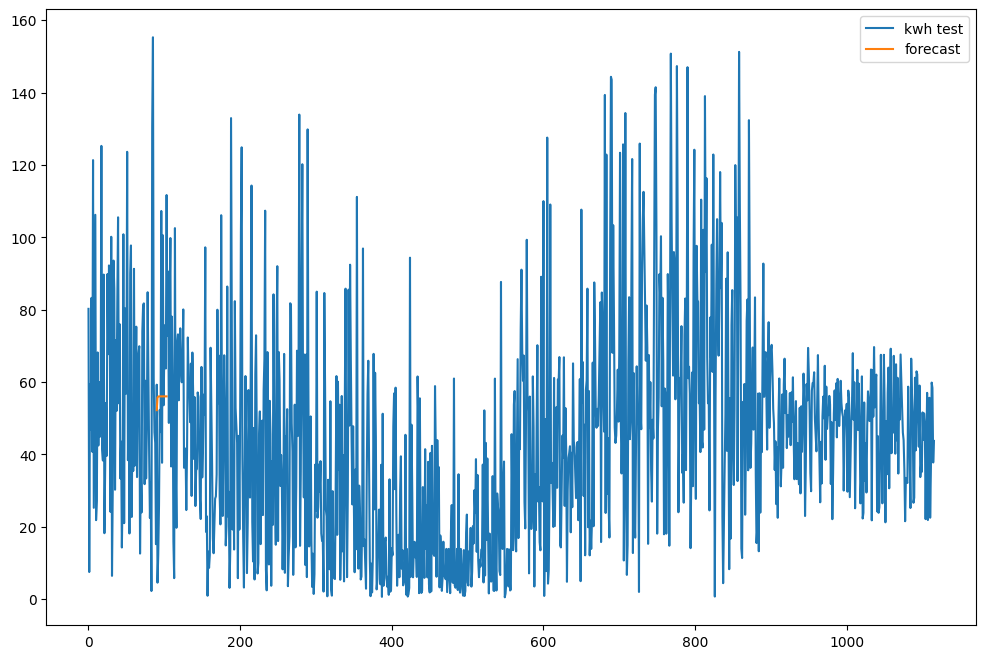

In [ ]:
dataset['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
dataset[['kwh test','forecast']].plot(figsize=(12,8))

In [ ]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(dataset['kwh test'],order=(1, 1, 1),seasonal_order=(1,1,1,60))
results=model.fit()

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates=[dataset['hours test'].iloc[-1]]

In [ ]:
import datetime,time
futured = str(future_dates)
print(futured)

#start_time = datetime.datetime.strptime(future_dates, '%H:%M')
start_time = datetime.datetime.strptime('23:59', '%H:%M')
newarr = []

for i in range(0,31):
  #start_time += datetime.timedelta(minutes=1)
  start_time += datetime.timedelta(minutes=1)
  newarr.append(start_time.strftime('%H:%M:%S'))
  #newd = start_time.strftime('%H:%M:%S')
print(newarr)
  #time.sleep(1)

['23:59']
['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00', '00:06:00', '00:07:00', '00:08:00', '00:09:00', '00:10:00', '00:11:00', '00:12:00', '00:13:00', '00:14:00', '00:15:00', '00:16:00', '00:17:00', '00:18:00', '00:19:00', '00:20:00', '00:21:00', '00:22:00', '00:23:00', '00:24:00', '00:25:00', '00:26:00', '00:27:00', '00:28:00', '00:29:00', '00:30:00']


In [ ]:
newfuture = np.array(newarr)
print(type(newarr))
print(newfuture)

<class 'list'>
['00:00:00' '00:01:00' '00:02:00' '00:03:00' '00:04:00' '00:05:00'
 '00:06:00' '00:07:00' '00:08:00' '00:09:00' '00:10:00' '00:11:00'
 '00:12:00' '00:13:00' '00:14:00' '00:15:00' '00:16:00' '00:17:00'
 '00:18:00' '00:19:00' '00:20:00' '00:21:00' '00:22:00' '00:23:00'
 '00:24:00' '00:25:00' '00:26:00' '00:27:00' '00:28:00' '00:29:00'
 '00:30:00']


In [ ]:
forecast_ARIMA = results.predict(start = 991, end = 1193, dynamic=True)

**Prediction Visualization**

In [ ]:
actual_test = go.Scatter(
    x = x_test,
    y = test_labels[:, 0],
    mode = 'lines',
    name = 'Actual Test Data'
)

rf_test_pred = go.Scatter(
    x = x_test,
    y = y_rf_pred,
    mode = 'lines',
    name = 'Random Forest Prediction'
)

svr_test_pred = go.Scatter(
    x = x_test,
    y = y_svr_pred,
    mode = 'lines',
    name = 'SVR Prediction'
)

xgb_test_pred = go.Scatter(
    x = x_test,
    y = y_xgb_pred,
    mode = 'lines',
    name = 'XGBoost Prediction'
)

nn_test_pred = go.Scatter(
    x = x_test,
    y = y_nn_pred_out,
    mode = 'lines',
    name = 'NN Prediction'
)

lstm_test_pred = go.Scatter(
    x = x_test,
    y = y_lstm_pred_out,
    mode = 'lines',
    name = 'LSTM Prediction'
)

ARIMA_test_pred = go.Scatter(
    x = x_test,
    y = forecast_ARIMA,
    mode = 'lines',
    name = 'SARIMA Prediction'
)

layout = go.Layout(
    #title = 'Load Forecasting',
    xaxis = {'title' : "Time"},
    yaxis = {'title' : "Kwh Delivered"}
)
fig = go.Figure(data=[actual_test,
                      nn_test_pred,
                      rf_test_pred,
                      ARIMA_test_pred],
                layout=layout)
fig.update_layout(
    legend=dict(
        x=.5,
        y=.05,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=16,
            color="black"
        ),
    )
)

**FORECASTING**

In [ ]:
FUTURE = 32

def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  for _ in range(into_future):

    future_pred = model.predict(np.expand_dims(last_window, axis=0))

    # print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred)}\n")

    future_forecast.append(np.squeeze(future_pred))

    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")

  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [ ]:
last_timestep = dataset['hours test'].iloc[-1]

last_timestep

'23:59'

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates=[dataset['hours test'].iloc[-1]]

In [ ]:
import datetime,time
futured = str(future_dates)
print(futured)

#start_time = datetime.datetime.strptime(future_dates, '%H:%M')
start_time = datetime.datetime.strptime('23:59', '%H:%M')
newarr = []

for i in range(0,31):
  #start_time += datetime.timedelta(minutes=1)
  start_time += datetime.timedelta(minutes=1)
  newarr.append(start_time.strftime('%H:%M:%S'))
  #newd = start_time.strftime('%H:%M:%S')
print(newarr)
  #time.sleep(1)

['23:59']
['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00', '00:06:00', '00:07:00', '00:08:00', '00:09:00', '00:10:00', '00:11:00', '00:12:00', '00:13:00', '00:14:00', '00:15:00', '00:16:00', '00:17:00', '00:18:00', '00:19:00', '00:20:00', '00:21:00', '00:22:00', '00:23:00', '00:24:00', '00:25:00', '00:26:00', '00:27:00', '00:28:00', '00:29:00', '00:30:00']


In [ ]:
newfuture = np.array(newarr)
print(type(newarr))
print(newfuture)

<class 'list'>
['00:00:00' '00:01:00' '00:02:00' '00:03:00' '00:04:00' '00:05:00'
 '00:06:00' '00:07:00' '00:08:00' '00:09:00' '00:10:00' '00:11:00'
 '00:12:00' '00:13:00' '00:14:00' '00:15:00' '00:16:00' '00:17:00'
 '00:18:00' '00:19:00' '00:20:00' '00:21:00' '00:22:00' '00:23:00'
 '00:24:00' '00:25:00' '00:26:00' '00:27:00' '00:28:00' '00:29:00'
 '00:30:00']


In [ ]:
future_forecast_rf = make_future_forecast(values=kwh,
                                          model=rf_regr,
                                          into_future=FUTURE,
                                          window_size=WINDOW_SIZE)

In [ ]:
future_forecast_rf

[array(31.17),
 array(42.047),
 array(39.553),
 array(61.748),
 array(53.347),
 array(49.564),
 array(47.662),
 array(42.21),
 array(44.843),
 array(41.044),
 array(55.761),
 array(40.985),
 array(45.142),
 array(39.436),
 array(36.842),
 array(39.474),
 array(54.06),
 array(41.514),
 array(47.565),
 array(53.339),
 array(52.868),
 array(41.977),
 array(32.695),
 array(48.019),
 array(52.77),
 array(69.147),
 array(57.043),
 array(50.717),
 array(41.386),
 array(36.735),
 array(52.292),
 array(43.367)]

In [ ]:
future_forecast_svr = make_future_forecast(values=kwh,
                                          model=svr_regr,
                                          into_future=FUTURE,
                                          window_size=WINDOW_SIZE)

In [ ]:
future_forecast_xgb = make_future_forecast(values=kwh,
                                          model=xgb_regr,
                                          into_future=FUTURE,
                                          window_size=WINDOW_SIZE)

In [ ]:
future_forecast_nn = make_future_forecast(values=kwh,
                                          model=nn_model,
                                          into_future=FUTURE,
                                          window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 24ms/step


In [ ]:
future_forecast_lstm = make_future_forecast(values=kwh,
                                          model=lstm_model,
                                          into_future=FUTURE,
                                          window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 26ms/step


In [ ]:
future_forecast_rf_steps = np.insert(future_forecast_rf, 0, kwh[-1])
future_forecast_svr_steps = np.insert(future_forecast_svr, 0, kwh[-1])
future_forecast_xgb_steps = np.insert(future_forecast_xgb, 0, kwh[-1])
future_forecast_nn_steps = np.insert(future_forecast_nn, 0, kwh[-1])
future_forecast_lstm_steps = np.insert(future_forecast_lstm, 0, kwh[-1])

In [ ]:
#next_time_steps, future_forecast_svr_steps

**Forecast Visualization**

In [ ]:
trace1 = go.Scatter(
    x = hours,
    y = kwh,
    mode = 'lines',
    name = 'Actual Data from Previous Day'
)

trace2 = go.Scatter(
    x = newfuture,
    y = future_forecast_rf_steps,
    mode = 'lines',
    name = 'Forecasted RF'
)

trace3 = go.Scatter(
    x = newfuture,
    y = future_forecast_svr_steps,
    mode = 'lines',
    name = 'Forecasted SVR'
)

trace4 = go.Scatter(
    x = newfuture,
    y = future_forecast_xgb_steps,
    mode = 'lines',
    name = 'Forecasted XGB'
)

trace5 = go.Scatter(
    x = newfuture,
    y = future_forecast_nn_steps,
    mode = 'lines',
    name = 'Forecasted NN'
)

trace6 = go.Scatter(
    x = newfuture,
    y = future_forecast_lstm_steps,
    mode = 'lines',
    name = 'Forecasted LSTM'
)
trace7 = go.Scatter(
    x = newfuture,
    y = forecast_ARIMA,
    mode = 'lines',
    name = 'Forecasted ARIMA'

)

layout = go.Layout(
    #title = 'Load Forecasting',
    xaxis = {'title' : "Time"},
    yaxis = {'title' : "kWh Delivered"}
)
#fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7], layout=layout)
fig = go.Figure(data=[trace1, trace2, trace5, trace7], layout=layout)
#fig.show()

fig.update_layout(
    legend=dict(
        x=.2,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=16,
            color="black"
        ),
    )
)